In [25]:
#Import libraries
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

## Data reading and wrangling

In [26]:
#set directory for results
res = 'run_v1/csv_results/'

In [27]:
#read parquet file with aggregated results
df = pd.read_parquet(res + 'all.parquet')

In [28]:
#create new columns

df['route_id'] = df['source'].str.split('_').str[1]
df['route_id'] = df['source'].str.split('_').str[1]
df['time_day'] = df['source'].str.split('_').str[2]
df['type'] = df['source'].str.split('_').str[3]
df

,value,distance,amount,s_exp,source,route_id,time_day,type
0,100.0,3664.9,29.87,54.837371,route_26_evening_shortest,26,evening,shortest
1,0.0,2981.3,24.30,54.837371,route_26_evening_shortest,26,evening,shortest
2,98.0,662.5,5.40,54.837371,route_26_evening_shortest,26,evening,shortest
3,4.0,483.6,3.94,54.837371,route_26_evening_shortest,26,evening,shortest
4,99.0,433.9,3.54,54.837371,route_26_evening_shortest,26,evening,shortest
...,...,...,...,...,...,...,...,...
19,83.0,31.1,0.67,85.248229,route_9_noon_recommended,9,noon,recommended
20,71.0,22.8,0.49,85.248229,route_9_noon_recommended,9,noon,recommended
21,97.0,22.0,0.48,85.248229,route_9_noon_recommended,9,noon,recommended
22,0.0,16.2,0.35,85.248229,route_9_noon_recommended,9,noon,recommended


In [29]:
#create dataset with aggregated distance
dfw = df.groupby('source')['distance'].sum()

dfw = dfw.to_frame().reset_index()



In [30]:
#create dataframe with relevant variables

df_exp = df[['source', 's_exp', 'time_day']]
df_exp = df_exp.drop_duplicates()

In [31]:
#merge dataframe
df_merged = dfw.merge(df_exp[['source', 's_exp', 'time_day']], on='source', how='inner')

df_merged['route_type'] = df_merged['source'].str.split('_').str[3]

df_merged

,source,distance,s_exp,time_day,route_type
0,route_0_afternoon_recommended,6622.1,40.459144,afternoon,recommended
1,route_0_afternoon_shortest,6147.6,47.105440,afternoon,shortest
2,route_0_evening_recommended,6438.3,30.749841,evening,recommended
3,route_0_evening_shortest,6436.9,30.038947,evening,shortest
4,route_0_morning_recommended,6267.9,51.355063,morning,recommended
...,...,...,...,...,...
315,route_9_evening_shortest,4541.2,52.284550,evening,shortest
316,route_9_morning_recommended,4470.6,7.392006,morning,recommended
317,route_9_morning_shortest,4387.8,7.005857,morning,shortest
318,route_9_noon_recommended,4629.6,85.248229,noon,recommended


## Length and solar exposure distribution

In [32]:
import pandas as pd
import seaborn as sns
import numpy as np

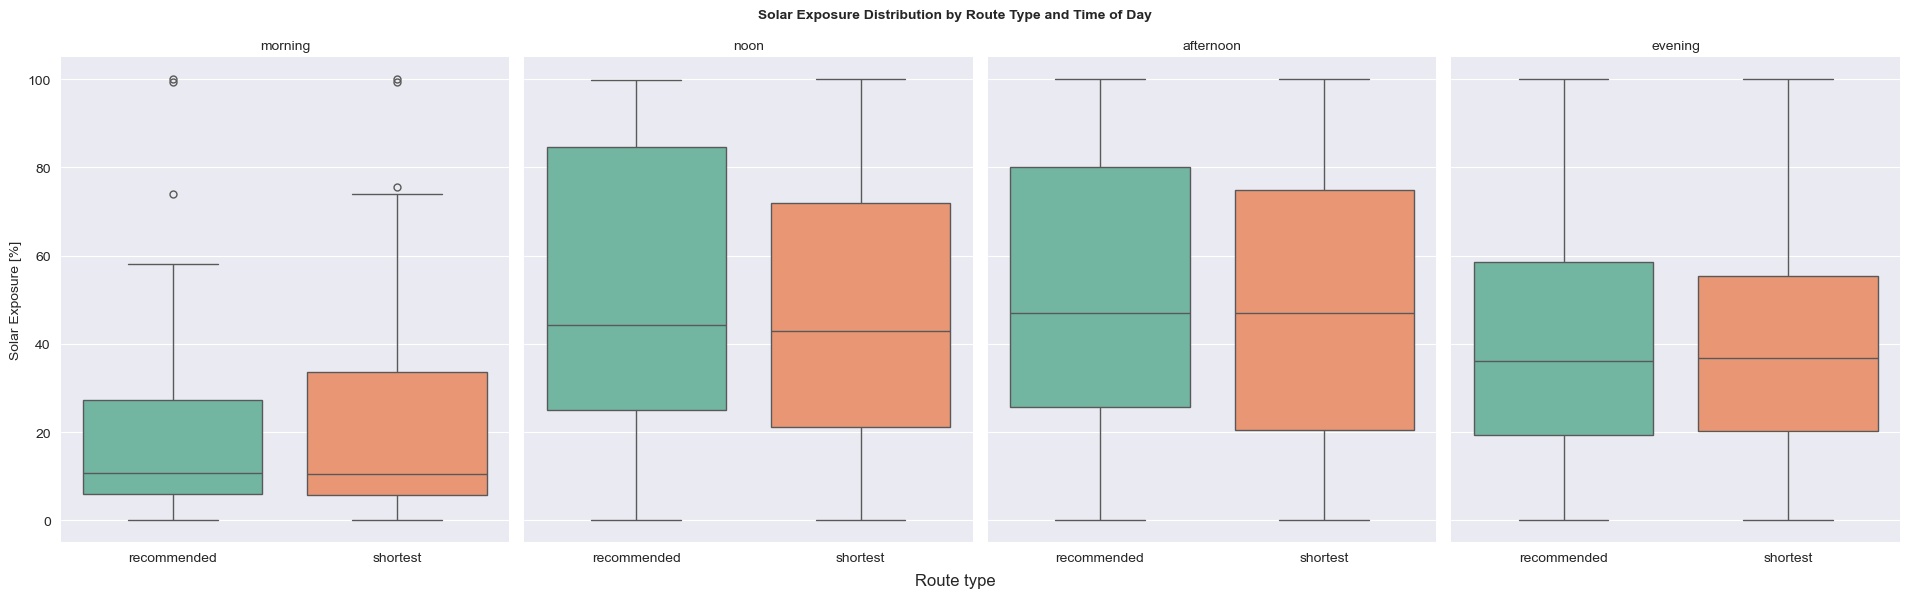

In [33]:
#first plot
palette = sns.color_palette("Set2", 2)

p = sns.catplot(
    kind='box',
    data=df_merged,
    x='route_type',
    y='s_exp',
    hue='route_type',
    legend=False,
    col='time_day',
    col_wrap=4,
    height=6,
    aspect=0.8,
    palette=palette,
    col_order=['morning', 'noon', 'afternoon', 'evening']
)


p.set_titles("{col_name}")
p.set_axis_labels("", "Solar Exposure [%]")
p.despine(left=True)
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle("Solar Exposure Distribution by Route Type and Time of Day", fontsize=10, fontweight='bold')


p.fig.text(0.5, 0.02, "Route type", ha='center', fontsize=12)

p.savefig("s_exp_route_type_timeofday.png", dpi=400, bbox_inches='tight')

plt.show()

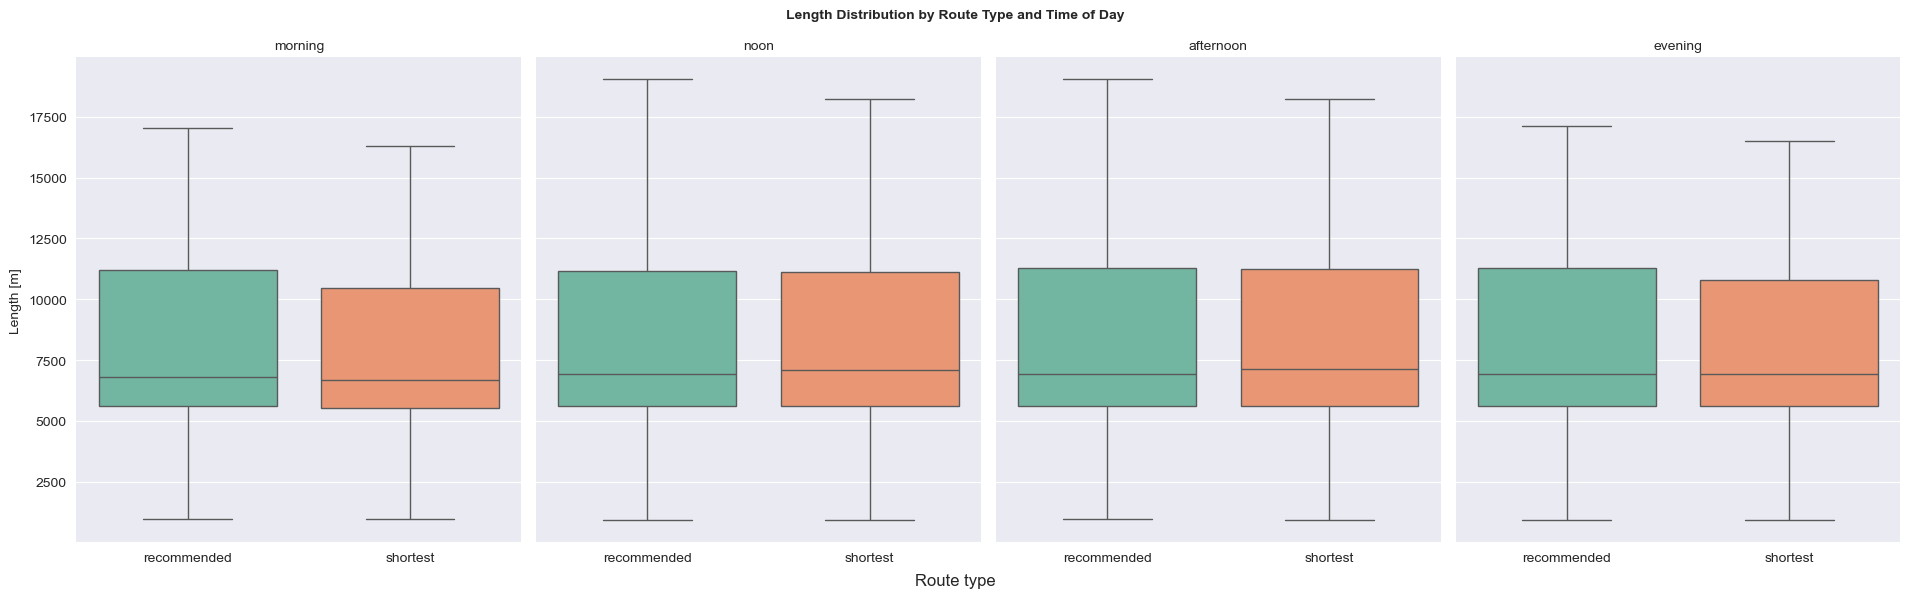

In [34]:
#second plot

palette = sns.color_palette("Set2", 2)

p = sns.catplot(
    kind='box',
    data=df_merged,
    x='route_type',
    y='distance',
    hue='route_type',
    legend=False,
    col='time_day',
    col_wrap=4,
    height=6,
    aspect=0.8,
    palette=palette,
    col_order=['morning', 'noon', 'afternoon', 'evening']
)


p.set_titles("{col_name}")
p.set_axis_labels("", "Length [m]")
p.despine(left=True)
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle("Length Distribution by Route Type and Time of Day", fontsize=10, fontweight='bold')


p.fig.text(0.5, 0.02, "Route type", ha='center', fontsize=12)

p.savefig("length_route_type_timeofday.png", dpi=400, bbox_inches='tight')

plt.show()

The first graphs shows boxplots sorted by route type and time of the day. The values that shape these boxplots is the solar exposure (%). Outliers are visible in the first boxplot, represented by dots on the top. One can clearly see that the sun exposure increases throughout the day. Surprisingly, the sun exposure is not really reduced when choosing the recommended route, which should be the route with less solar exposure.
The second graph shows the boxplots sorted by route type and time of the day, but filled with the route length (m). It is interesting to see that the length of the route does not vary during the day. During the morning and the evening, the routes are significantly shorter than the recommended routes.

## Find biggest length difference

In [35]:
df_merged['source_no_route'] = df_merged['source'].str.rsplit('_', n=1).str[0]
df_merged

,source,distance,s_exp,time_day,route_type,source_no_route
0,route_0_afternoon_recommended,6622.1,40.459144,afternoon,recommended,route_0_afternoon
1,route_0_afternoon_shortest,6147.6,47.105440,afternoon,shortest,route_0_afternoon
2,route_0_evening_recommended,6438.3,30.749841,evening,recommended,route_0_evening
3,route_0_evening_shortest,6436.9,30.038947,evening,shortest,route_0_evening
4,route_0_morning_recommended,6267.9,51.355063,morning,recommended,route_0_morning
...,...,...,...,...,...,...
315,route_9_evening_shortest,4541.2,52.284550,evening,shortest,route_9_evening
316,route_9_morning_recommended,4470.6,7.392006,morning,recommended,route_9_morning
317,route_9_morning_shortest,4387.8,7.005857,morning,shortest,route_9_morning
318,route_9_noon_recommended,4629.6,85.248229,noon,recommended,route_9_noon


In [50]:
wide_df = df_merged.pivot(
    index='source_no_route',
    columns='route_type',
    values='distance'
)

In [52]:

big_diff = (wide_df['recommended'] - wide_df['shortest']).abs().idxmax()
big_diff

'route_22_noon'

In [53]:
#plot with folium
gdf1 = gpd.read_file(f'../data/run_v1/01_raw/01_routes/{big_diff}_recommended.geojson')
gdf2= gpd.read_file(f'../data/run_v1/01_raw/01_routes/{big_diff}_shortest.geojson')

df1 = df_merged[df_merged['source'] == f'{big_diff}_recommended']
df2 = df_merged[df_merged['source'] == f'{big_diff}_shortest']

gdf1['solar_exp'] = df1.iloc[0]['s_exp']
gdf1['source'] = df1.iloc[0]['source']
gdf2['solar_exp'] = df2.iloc[0]['s_exp']
gdf2['source'] = df2.iloc[0]['source']


gdf_combined = pd.concat([gdf1, gdf2], ignore_index=True)

gdf_combined


Skipping field way_points: unsupported OGR type: 1
Skipping field way_points: unsupported OGR type: 1


,ascent,descent,extras,summary,geometry,solar_exp,source
0,125.5,229.0,"{ ""csv"": { ""values"": [ [ 0, 8, 0 ], [ 8, 10, 7...","{ ""distance"": 7545.0, ""duration"": 5432.3000000...","LINESTRING Z (8.68909 49.44104 213, 8.6897 49....",84.486991,route_22_noon_recommended
1,478.5,582.0,"{ ""csv"": { ""values"": [ [ 0, 55, 0 ], [ 55, 73,...","{ ""distance"": 9687.3999999999996, ""duration"": ...","LINESTRING Z (8.68909 49.44104 213, 8.6897 49....",41.638396,route_22_noon_shortest


In [47]:
import folium
import branca

m = folium.Map([49.4, 8.7], zoom_start=12, tiles='cartodbpositron')

min_val = gdf_combined['solar_exp'].min()
max_val = gdf_combined['solar_exp'].max()
colormap = branca.colormap.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],
    vmin=min_val,
    vmax=max_val,
    caption='Solar Exposure'
)



for source in gdf_combined['source'].unique():
    fg = folium.FeatureGroup(name=f"Route: {source}")
    
    geojson = folium.GeoJson(
        gdf_combined[gdf_combined['source'] == source],
        style_function=lambda feature, cmap=colormap: {
            'color': cmap(feature['properties']['solar_exp']),
            'weight': 3,
            'opacity': 1
        }
    )
    
    geojson.add_to(fg)
    fg.add_to(m)

folium.LayerControl().add_to(m)

colormap.add_to(m)

m


The route pair with the largest difference in length between the shaded and shortest routes was identified using absolute values, since some differences were negative. This route pair was then selected, and the corresponding GeoJSON files were loaded onto the map. By examining the map, one can see why the difference in length is so large and why the longer detour has lower solar exposure. The blue route, which receives less solar exposure, passes through the forest, while the red route crosses the city of Heidelberg. Although the blue route also passes through Heidelberg, its solar exposure is reduced due to the initial kilometers through the forest.

## Find biggest Solar exposure difference

In [61]:
wide_df = df_merged.pivot(
    index='source_no_route',
    columns='route_type',
    values='s_exp'
)

In [58]:
big_diff = (wide_df['recommended'] - wide_df['shortest']).abs().idxmax()
big_diff

'route_22_noon'

In [59]:
gdf1 = gpd.read_file(f'../data/run_v1/01_raw/01_routes/{big_diff}_recommended.geojson')
gdf2= gpd.read_file(f'../data/run_v1/01_raw/01_routes/{big_diff}_shortest.geojson')

df1 = df_merged[df_merged['source'] == f'{big_diff}_recommended']
df2 = df_merged[df_merged['source'] == f'{big_diff}_shortest']

gdf1['solar_exp'] = df1.iloc[0]['s_exp']
gdf1['source'] = df1.iloc[0]['source']
gdf2['solar_exp'] = df2.iloc[0]['s_exp']
gdf2['source'] = df2.iloc[0]['source']


gdf_combined = pd.concat([gdf1, gdf2], ignore_index=True)

gdf_combined

Skipping field way_points: unsupported OGR type: 1
Skipping field way_points: unsupported OGR type: 1


,ascent,descent,extras,summary,geometry,solar_exp,source
0,125.5,229.0,"{ ""csv"": { ""values"": [ [ 0, 8, 0 ], [ 8, 10, 7...","{ ""distance"": 7545.0, ""duration"": 5432.3000000...","LINESTRING Z (8.68909 49.44104 213, 8.6897 49....",84.486991,route_22_noon_recommended
1,478.5,582.0,"{ ""csv"": { ""values"": [ [ 0, 55, 0 ], [ 55, 73,...","{ ""distance"": 9687.3999999999996, ""duration"": ...","LINESTRING Z (8.68909 49.44104 213, 8.6897 49....",41.638396,route_22_noon_shortest


In [60]:
import folium
import branca

m = folium.Map([49.4, 8.7], zoom_start=12, tiles='cartodbpositron')

min_val = gdf_combined['solar_exp'].min()
max_val = gdf_combined['solar_exp'].max()
colormap = branca.colormap.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],
    vmin=min_val,
    vmax=max_val,
    caption='Solar Exposure'
)



for source in gdf_combined['source'].unique():
    fg = folium.FeatureGroup(name=f"Route: {source}")

    geojson = folium.GeoJson(
        gdf_combined[gdf_combined['source'] == source],
        style_function=lambda feature, cmap=colormap: {
            'color': cmap(feature['properties']['solar_exp']),
            'weight': 3,
            'opacity': 1
        }
    )

    geojson.add_to(fg)
    fg.add_to(m)

folium.LayerControl().add_to(m)

colormap.add_to(m)

m

The route pair with the largest difference in solar exposure between the shaded and shortest routes was also identified using absolute values, since some differences were negative. One can clearly see here that in this case, the gap is affected by the longer route passing through the forest, which significantly reduces the heat stress along the way. However, one aspect dad we did not consider in this plot is the elevation differences. This could also be an important factor, since paths along the forest are not always flat. One has to choose between a straight, quicker path across the city or the more scenic path across the forest, taking into account that the terrain can be an issue.

## Correlation Matrix


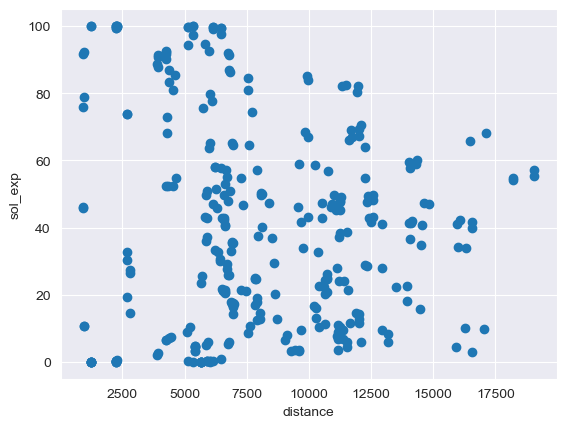

In [45]:
#extract values from dataframe
distance = df_merged["distance"]
sol_exp = df_merged["s_exp"]

plt.plot(distance, sol_exp, "o")
plt.xlabel("distance")
plt.ylabel("sol_exp")
plt.show()

In [46]:
#calculate correlation coefficient
x = distance.copy()
y = sol_exp.copy()
x_bar = np.mean(distance)
y_bar = np.mean(sol_exp)

np.sum((x - x_bar) * (y - y_bar)) / (
    np.sqrt(np.sum((x - x_bar) ** 2)) * np.sqrt(sum((y - y_bar) ** 2))
)


(
    np.cov(x, y) / (np.std(x) * np.std(y))
)



print(np.corrcoef(x, y)[0, 1])


-0.10094914834803095


Since we are dealing with a lot of data points, I thought that a simple correlation plot could be important to identify trends which can't be seen on a map. The plot above shows the correlation between the distance and the solar exposure. It is challenging to identify a trend. However, it's interesting to see that the solar exposure is slightly reduced with increasing distance. This could be related to the fact that many long routes pass through the forest.
I also calculated the correlation coefficient. It's really low and negative (-0.100) which means that there isn't a linear relationship, and if there is one, it's doubtful. A more suited approach would be a Generalized Linear Model (GLM) with binary data, since we also have this type of data in our variables.